# Predicting Stock Prices with Reddit Comments
### Author: Katie Kemp

# Motivation

In January 2021, the subreddit r/wallstreetbets became very famous for its influence on the stock market. Reddit is social media website where users can semi-anonymously post content and comment on it. It allows users with similar interests engage on topics and filters information based on positive engagement. The stock market has long been controlled by the rich, as the more money a person has the more influence they have on the market. By allowing users to communicate in real time, reddit users in r/wallstreetbets were able to work together to influence the market, most notably causing the stock for Gamestop, GME, to rise from about $40 on January 20 to about $450 on January 28. They did this to spite the hedge funds who had bet against Gamestop, essentially gambling money on the fact that GME would not rise past a certain price. To understand this better see this article: https://www.cnn.com/2021/12/19/investing/stocks-week-ahead-reddit-wallstreetbets-gamestop/index.html.

Clearly there are big gains to be earned through understanding the stock market and communicating with others on r/wallstreetbets, but it takes a long time to sift through comments and know when to buy and when to sell. Perhaps there is a way to aggregate the information on r/wallstreetbets to inform a trader when to buy and sell without reading the actual prose.

The simplest indicator of “big gains” might be that everyone is talking about that stock. By setting up a bot to read r/wallstreetbets comments and scanning the content to see the frequency of mentions of that stock, we can see how much people are talking about a stock. We can get data about the stock price and see if it is possible to predict the change in stock price a certain amunt of time in advance. We can exmine how accurate it is. Even if we cannot predict the exact stock price very well, we may still be able to give a good idea of when to sell in order to minimize losses, or at least begin to understand the correlation between people talking about a stock and its price.

# Data Collection

## Obtaining Data from Reddit

There are several ways to set up a Reddit bot in order to obtain information about comment and post content.  After experimenting with using the raw Reddit API, PRAW, PSAW, and PMAW, I ended up going with PMAW. PRAW, PSAW, and PMAW are Pushshift's Python libraries for using the Reddit API, with an additional layer of abstraction that makes it easier to use. The Reddit API alone does not let you request comments or posts within a given time. You can work your way back to the time period you wish to examine by getting a certain number of posts before a given post, but this can be complicated and time consuming. The Pushshift libraries allow you to do this and more, but PMAW is specialized for large datasets, so that is what I went with. To learn more about using the Reddit API, check out this tutorial: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c, and for a quickstart on PMAW, check out https://medium.com/swlh/how-to-scrape-large-amounts-of-reddit-data-using-pushshift-1d33bde9286.

It’s important to note that Pushshift has an aggregate functionality, which allows you to skip over a lot of the data analysis I will have to do manually in a single line. You can do this using the aggs parameter and specifying the frequency at which you aggregate information. Then you can get data about how frequently a word is used each hour. From my research, the aggs command appears to be disabled, but if it is available you can read about it here: https://github.com/pushshift/api.


It took a lot of experimenting with the capavilities of the different libraries, but once I decided on what information I wanted, the process boiled down to something pretty simple. First, install and import pmaw. 

    !pip3 install pmaw
    import pmaw
    import pandas as pd

Next, set up the first time period, I wanted to collect data for, for me it was 24 hours prior to 12/15/21 at noon.

    seconds_per_day = 60 * 60 * 24
    before = int(dt.datetime(2021,12,15,12,0).timestamp())
    after = before - seconds_per_day

If desired, set a specific subreddit to target and the number of requests you want to make at a time. 

    subreddit = 'wallstreetbets'
    limit = 100

Initialize the 'PushshiftAPI' object and a 'pandas' dataframe.

    api = pmaw.PushshiftAPI()
    df = pd.DataFrame()

As I already said, I decided to collect data from noon to noon on the next day, and here I set up a loop to do this for 90 connsecutive days before 12/15

    for i in range(90):
        comments = api.search_comments(subreddit=subreddit, limit=limit, before=before, after=after)
        for comment in comments:
            df = df.append({'author' : comment['author'],'body': comment['body'], 'created_utc' :comment['created_utc'], 'score' : comment['score'], 'awards' : comment['total_awards_received']}, ignore_index=True)
        before -= seconds_per_day
        after = before - seconds_per_day

You can use the 'search_comment()' function to search Reddit comments, or 'search_submissions' funtction to search posts. Using the API documentation (https://reddit-api.readthedocs.io/en/latest/) I was able to set the right parameters for what I needed. Next, I added each of the 100 comments to the dataframe, extraxcting only the parameters that I thought would be potentially useful.

'author', 'body', and 'awards' are self explanatory, but 'created_utc' is the epoch time measured in seconds that the post was created at, and the 'score' is given by Reddit based on positive engagement (mainly upvotes vs. downvotes). There are more interesting parameters to be taken from a submission than a comment, but I found scanning comments was more useful for what I wanted to measure so I did not extract posts. To get all information that pmaw provides from a request, just print it out. You will see a dictionary where most keys are self explanatory, and any that are not can be researched further in pmaw or the Reddit API itself.
        
Lastly, I saced the dataframe as a csv, as this data to about 30 inutes to retrieve. I made 90 requests of 100 records, and request does take a significant amount of time. The Reddit API returns a maximum of 100 records per request at a limit of 60 request per minute. If you set limit higher than 100, pmaw knows to make multiple requests. In reality, we do not get anywhere close to the optimal request rate, so be careful when making a large number of requests without saving in between, as it would be easy to lose a large amount of data.

To save the csv, make a zip file with the desired title and use 'to_csv()' to put the pandas dataframe inside.

    compression_opts = dict(method='zip', archive_name='comments.csv')  
    df.to_csv('comments.zip', index=False, compression=compression_opts)'
          
The rest of the tutorial will use the csv I saved here, in order to protect against data loss.


## Obtaining Stock Market Data

Unlike Reddit content, stock market data is readily available in many locations. I used Yahoo Finance. I searched the ticker for the stock of interest, I chose Tesla (TSLA), Amazon (AMZN), Pfizer (PFE), and Gamestop (GME) because these are  stocks that I have investments in and/or I thought would be interesting to look at. You can then click “historical data” for the stock and request data for a specific time period at a specific frequency, and download it as a csv.

I uploaded the csvs to this folder so that they could be imported as pandas dataframes. For quickstart on Yahoo Finance, check out https://help.yahoo.com/kb/SLN2311.html.

# Data Processing

The first step to data processing is importing it into a dataframe, as I did for each stock, as well as the comments. I also imported all of the libraries that I will use throughout the tutorial.

In [1]:
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy import stats

tsla = pd.read_csv("TSLA.csv")
amzn = pd.read_csv("AMZN.csv")
pfe = pd.read_csv("PFE.csv")
gme = pd.read_csv("GME.csv")

comments = pd.read_csv("comments.csv")
comments.head()

,author,awards,body,created_utc,score
0,HowlLaika,0.0,Its not you WHOLE savings. You still got 16 th...,1.639492e+09,1.0
1,lulu_butts,0.0,Screen shot that and complain to customer service,1.639492e+09,1.0
2,Fuji-one,0.0,I need to sell my car to buy more calls,1.639492e+09,1.0
3,pajamental805,0.0,Rip,1.639492e+09,1.0
4,AskMeAboutL00M,0.0,don't listen to all these people who tell you ...,1.639492e+09,1.0


For a lot of this tutorial, code is repetitive for each stock, so I will only add detailed comments and explanation for Tesla. 

The main data processing necessary for the stock market data involved deciding on what price metric to use. I decided to take an average of open and close price each day because tha seems like a fair method that wouldn't make the stock look more or less expensive that it actuall is. I also had to format the date properly so that it would be easy to compare with the date that I will retreieve from the Reddit comments, and make sense to a human looking at a graph.

In [2]:
lst = [0] * len(tsla) # List of zeroes to add an average price to
lst1 = [''] * len(tsla) # list of zeroes to add correctly formmatted date to
for index, row in tsla.iterrows():
    lst[index] = .5 * (row['Open'] + row['Close']) # Take the average of open and close price
    x = row['Date'].split('/')
    lst1[index] = str(datetime.datetime(int('20' + x[2]),int(x[0]),int(x[1])).date()) # Format the data as a string of the date object
tsla['Date'] = lst1 # Add the new data and mean price t the dataframe
tsla['mean'] = lst

# Create a dictionary that maps the date to a mean price for that stock
date = list(tsla['Date']) 
mean = list(tsla['mean'])
tsla_dict = {date[i]: mean[i] for i in range(len(tsla))}

lst = [0] * len(amzn)
lst1 = [''] * len(amzn)
for index, row in amzn.iterrows():
    lst[index] = .5 * (row['Open'] + row['Close'])
    x = row['Date'].split('/')
    lst1[index] = str(datetime.datetime(int('20' + x[2]),int(x[0]),int(x[1])).date())
amzn['Date'] = lst1
amzn['mean'] = lst
date = list(amzn['Date'])
mean = list(amzn['mean'])
amzn_dict = {date[i]: mean[i] for i in range(len(amzn))}

lst = [0] * len(pfe)
lst1 = [''] * len(pfe)
for index, row in pfe.iterrows():
    lst[index] = .5 * (row['Open'] + row['Close'])
    x = row['Date'].split('/')
    lst1[index] = str(datetime.datetime(int('20' + x[2]),int(x[0]),int(x[1])).date())
pfe['Date'] = lst1
pfe['mean'] = lst
date = list(pfe['Date'])
mean = list(pfe['mean'])
pfe_dict = {date[i]: mean[i] for i in range(len(pfe))}

lst = [0] * len(gme)
lst1 = [''] * len(gme)
for index, row in gme.iterrows():
    lst[index] = .5 * (row['Open'] + row['Close'])
    x = row['Date'].split('/')
    lst1[index] = str(datetime.datetime(int('20' + x[2]),int(x[0]),int(x[1])).date())
gme['Date'] = lst1
gme['mean'] = lst
date = list(gme['Date'])
mean = list(gme['mean'])
gme_dict = {date[i]: mean[i] for i in range(len(gme))}

Next, I processed the Reddit comments. I ussed regexes to find instances of the stock beinng mentioned in the body of a comment. I looked for two things, the name of the comapny, like 'Tesla' or the ticker, like 'TSLA', in any combination of upper and lower case. An improvement that could definitely be made would be to include other relevant terms, like "Elon' or 'Bezos'. I also converted the date from epoch time. Lastly, I looked up the price for each stock in the corresponding dictionaries I amde in the last step, and added that to the dataframe. Since Yahoo Finance doesn't list the stock price on the days the market is not open, I just carried over the price from Friday on Saturdays and Sundays, so that valuable comment information didn't go to waste. All that is left to do is update the dataframe.

In [3]:
lst1 = [0] * len(comments) # Empty lists for various columns to be added to the dataframe
lst2 = [0] * len(comments)
lst3 = [0] * len(comments)
lst4 = [0] * len(comments)
lst5 = [0] * len(comments)
lst6 = [''] * len(comments)
lst7 = [''] * len(comments)
lst8 = [''] * len(comments)
lst9 = [''] * len(comments)
lst10 = [None] * len(comments)
for index, row in comments.iterrows():
    
    # Regexes for each company
    lst1[index] = len(re.findall('[Aa][Mm][Zz][Nn]|[Aa][Mm][Aa][Zz][Oo][Nn]', row['body']))
    lst2[index] = len(re.findall('[Tt][Ss][Ll][Aa]|[Tt][Ee][Ss][Ll][Aa]', row['body']))
    lst3[index] = len(re.findall('[Gg][Mm][Ee]|[Gg][Aa][Mm][Ee][Ss][Tt][Oo][Pp]', row['body']))
    lst4[index] = len(re.findall('[Pp][Ff][Ee]|[Pp][Ff][Ii][Zz][Ee][Rr]', row['body']))
    date = datetime.datetime.fromtimestamp(row['created_utc']) # Create date from epoch time
    lst10[index] = date.date()
    lst5[index] = str(date.date())

    # Add Tesla's price on the given date
    if lst5[index] in tsla_dict:
        lst6[index] = tsla_dict[lst5[index]]
    elif str((date - datetime.timedelta(days=1)).date()) in tsla_dict:
        lst6[index] = tsla_dict[str((date - datetime.timedelta(days=1)).date())]
    else:
        lst6[index] = tsla_dict[str((date - datetime.timedelta(days=1) -  datetime.timedelta(days=1)).date())]
    
    # Add Amazon's price on the given date
    if lst5[index] in amzn_dict:
        lst7[index] = amzn_dict[lst5[index]]
    elif str((date - datetime.timedelta(days=1)).date()) in amzn_dict:
        lst7[index] = amzn_dict[str((date - datetime.timedelta(days=1)).date())]
    else:
        lst7[index] = amzn_dict[str((date - datetime.timedelta(days=1) -  datetime.timedelta(days=1)).date())]
    
    # Add Pfizer's price on the given date
    if lst5[index] in pfe_dict:
        lst8[index] = pfe_dict[lst5[index]]
    elif str((date - datetime.timedelta(days=1)).date()) in pfe_dict:
        lst8[index] = pfe_dict[str((date - datetime.timedelta(days=1)).date())]
    else:
        lst8[index] = pfe_dict[str((date - datetime.timedelta(days=1) -  datetime.timedelta(days=1)).date())]
    
     # Add Gamestop's price on the given date
    if lst5[index] in gme_dict:
        lst9[index] = gme_dict[lst5[index]]
    elif str((date - datetime.timedelta(days=1)).date()) in gme_dict:
        lst9[index] = gme_dict[str((date - datetime.timedelta(days=1)).date())]
    else:
        lst9[index] = gme_dict[str((date - datetime.timedelta(days=1) -  datetime.timedelta(days=1)).date())]
    
# Add all the new comments to the dataframe
comments['amzn'] = lst1
comments['tsla'] = lst2
comments['gme'] = lst3
comments['pfe'] = lst4
comments['datetime'] = lst5
comments['tsla_price'] = lst6
comments['amzn_price'] = lst7
comments['pfe_price'] = lst8
comments['gme_price'] = lst9
comments['date'] = lst10
comments.head() 

,author,awards,body,created_utc,score,amzn,tsla,gme,pfe,datetime,tsla_price,amzn_price,pfe_price,gme_price,date
0,HowlLaika,0.0,Its not you WHOLE savings. You still got 16 th...,1.639492e+09,1.0,0,0,0,0,2021-12-14,951.755005,3366.415039,55.155,139.345001,2021-12-14
1,lulu_butts,0.0,Screen shot that and complain to customer service,1.639492e+09,1.0,0,0,0,0,2021-12-14,951.755005,3366.415039,55.155,139.345001,2021-12-14
2,Fuji-one,0.0,I need to sell my car to buy more calls,1.639492e+09,1.0,0,0,0,0,2021-12-14,951.755005,3366.415039,55.155,139.345001,2021-12-14
3,pajamental805,0.0,Rip,1.639492e+09,1.0,0,0,0,0,2021-12-14,951.755005,3366.415039,55.155,139.345001,2021-12-14
4,AskMeAboutL00M,0.0,don't listen to all these people who tell you ...,1.639492e+09,1.0,0,0,0,0,2021-12-14,951.755005,3366.415039,55.155,139.345001,2021-12-14


# Exploratory Analysis and Data Visualization

After making necessary changes to the data, it is time to take a first look at what we have. I graphed the price over time along with the comments over time, and saw something like what I expected. The amount of comments containing the stock peaks a bit before the price peaks. I looked up the dates for the corresponding maxes and found what I call the "lag time", or the time the stock response lags behind the comment volume. 

## Tesla

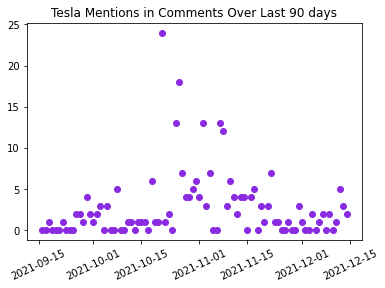

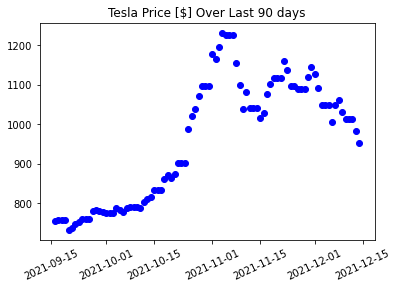

The lag between the max comments and max price is 14 days, 0:00:00


In [4]:
x = list(set(comments['date'])) # Get all the dates
colors = mcolors.CSS4_COLORS # Get a list of colors that we can use in graphs
c = list(colors.keys())[:len(x)]
colors = [colors[item] for item in c]

y = {} # The comment volume for each day
yy = {} # The price for each day
for date in x:
    y[date] = sum(comments[comments['date'] == date]['tsla']) # The comment volume is the sum of all instances of the phrases for that day, which corresponds to 100 comments
    yy[date] = max(comments[comments['date'] == date]['tsla_price']) # The price for all comments on that day will be the same, so I just took the max arbitrarily
y1 = [y[item] for item in x] # Get lists for comments and price in the order of the corresponding dates in x
y2 = [yy[item] for item in x]

# Graph Comments
fig, ax = plt.subplots()
plt.scatter(x=x, y=y1, color=colors[10])
plt.title("Tesla Mentions in Comments Over Last 90 days")
plt.xticks(rotation=25)

# Graph Price
fig, ax = plt.subplots()
plt.scatter(x=x, y=y2, color=colors[9])
plt.title("Tesla Price [$] Over Last 90 days")
plt.xticks(rotation=25)
plt.show()

# Calculate lag by indexing days in the corresponding dictionary and subtracting.
tsla_lag = list(yy.keys())[list(yy.values()).index(max(y2))] - list(y.keys())[list(y.values()).index(max(y1))]
print(f'The lag between the max comments and max price is {tsla_lag}')

# Analysis, Hypotheis Testing, and Machine Learning

From the data visualization we can not make a hypothesis that an increase in comment volume is correlated with an increase in stock price. 

My null hypothesis is that the change in stock price is not correlated with the change in comment volume.

I did a linear regression in order to examine this hypothesis.

## Tesla

The results of linear regression can be represented by the function y = 10.052571766375781 * x + 934.6818885356132.
The correlation coefficient is 0.26456272238722056.
The p-value is 0.011740506199118251.


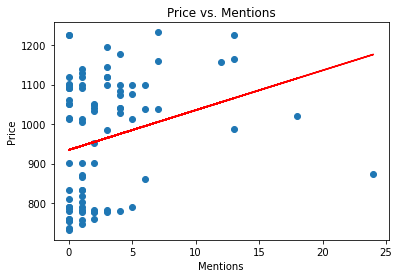

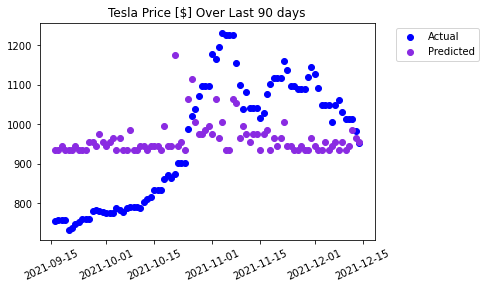

In [5]:
a = np.array(y1)
b = np.array(y2)
plt.scatter(x=a, y=b) # Scatter price vs. comments

# Use stats to get a linear regression model for price and comments column
m, yint, r, p, se = stats.linregress(a, b)

# Print relevant info about the model
print(f'The results of linear regression can be represented by the function y = {m} * x + {yint}.')
print(f'The correlation coefficient is {r}.')
print(f'The p-value is {p}.')

# Plot the line of regression
plt.plot(a, m*a+yint, 'r')
plt.title("Price vs. Mentions")
plt.xlabel('Mentions')
plt.ylabel('Price')
plt.show()

# Calculate the predicted price based on comments each day and plot it with the actual price
y3 = [m*item+yint for item in y1]
fig, ax = plt.subplots()
plt.scatter(x=x, y=y2, color=colors[9])
plt.scatter(x=x, y=y3, color=colors[10])
plt.title("Tesla Price [$] Over Last 90 days")
plt.legend(["Actual", "Predicted"], bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')
plt.xticks(rotation=25)
plt.show()

A p-value of <= .05 is considered significant, so this linear regression passes the test. Comments do in fact seem to have a correlation with price. However, I wasn't satisfied with this as I stated before that I noticed a lag between the response. I decided to try shifting the price data back by the lag time, doing another linear regression, getting the predictions, and shifting them back to the actual date.

The results of linear regression can be represented by the function y = 12.093862370798323 * x + 963.4208488349732.
The correlation coefficient is 0.3782804813112627.
The p-value is 0.0007537381590420461.


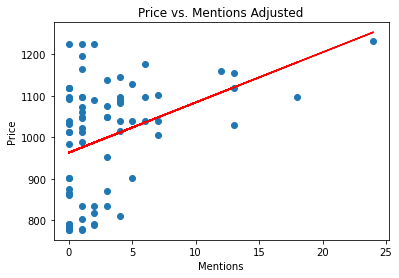

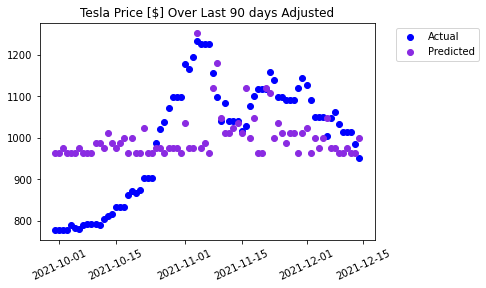

In [6]:
yyy = {} # adjusted prices
for key in yy.keys(): # Shift all of the priecs back by the lag
    yyy[key - tsla_lag] = yy[key]
    
adjusted_price = [] # adjusted price
new_mentions = [] # corresponding comments to adjusted price
days = [] # corresponding day
for key in yyy.keys(): # For each item in the adjsuted price array, add it to a new list if the date is also in the original array
    if key in y.keys():
        new_mentions.append(y[key])
        adjusted_price.append(yyy[key])
        days.append(key)

# Scatter price vs. comments
a = np.array(new_mentions)
b = np.array(adjusted_price)
plt.scatter(x=a, y=b)

# Use stats to get a linear regression model for year and lifeExp column
m, yint, r, p, se = stats.linregress(a, b)

# Print relevant info about the model
print(f'The results of linear regression can be represented by the function y = {m} * x + {yint}.')
print(f'The correlation coefficient is {r}.')
print(f'The p-value is {p}.')

# Calculate line of regression and plot on top of scatter
plt.plot(a, m*a+yint, 'r')
plt.title("Price vs. Mentions Adjusted")
plt.xlabel('Mentions')
plt.ylabel('Price')
plt.show()

# Shift the days back
days = [item+tsla_lag for item in days]
new_actual_price = []
for day in days:
    new_actual_price.append(yy[day]) # Add the actual prices on those days
new_predicted_price = [m*item+yint for item in new_mentions] # Calculate the predicted prices on those days

# Plot the predicted and actual prices for the overlapping time period
fig, ax = plt.subplots()
plt.scatter(x=days, y=new_actual_price, color=colors[9])
plt.scatter(x=days, y=new_predicted_price, color=colors[10])
plt.title("Tesla Price [$] Over Last 90 days Adjusted")
plt.legend(["Actual", "Predicted"], bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')
plt.xticks(rotation=25)
plt.show()

The p-value is indeed much lower, and the predictions much better. The predictions are still not great when the price is lower, but the model does tell us when the max will be, which tells us when to sell the stock.

Next I will do use the same approach on the other three stocks, without unnecesary re-explanation. I skipped to the linear regression adjusted for lag time.

## Amazon

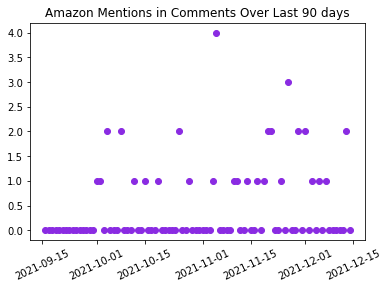

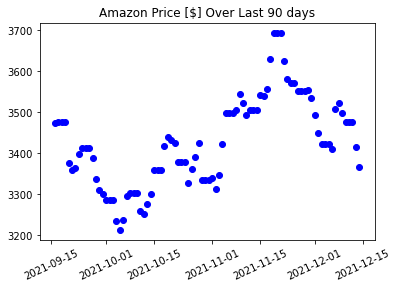

The lag between the max comments and max price is 14 days, 0:00:00


In [7]:
y = {}
yy = {}
for date in x:
    y[date] = sum(comments[comments['date'] == date]['amzn'])
    yy[date] = max(comments[comments['date'] == date]['amzn_price'])
y1 = [y[item] for item in x]
y2 = [yy[item] for item in x]

fig, ax = plt.subplots()
plt.scatter(x=x, y=y1, color=colors[10])
plt.title("Amazon Mentions in Comments Over Last 90 days")
plt.xticks(rotation=25)

fig, ax = plt.subplots()
plt.scatter(x=x, y=y2, color=colors[9])
plt.title("Amazon Price [$] Over Last 90 days")
plt.xticks(rotation=25)
plt.show()

amzn_lag = list(yy.keys())[list(yy.values()).index(max(y2))] - list(y.keys())[list(y.values()).index(max(y1))]
print(f'The lag between the max comments and max price is {amzn_lag}')

The results of linear regression can be represented by the function y = 30.357386505423037 * x + 3420.1116369582423.
The correlation coefficient is 0.20899026316167535.
The p-value is 0.07001659947643961.


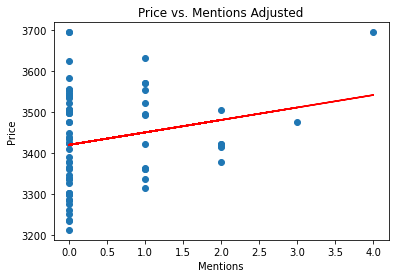

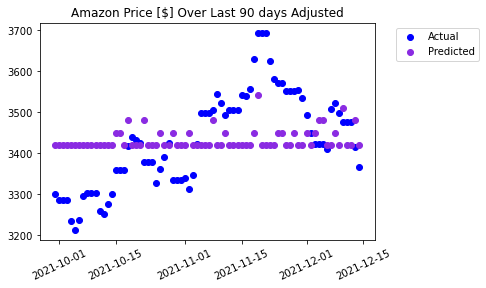

In [8]:
yyy = {} # adjusted prices
for key in yy.keys(): # Shift all of the priecs back by the lag
    yyy[key - amzn_lag] = yy[key]
    
adjusted_price = [] # adjusted price
new_mentions = []
days = [] # corresponding day
for key in yyy.keys(): # For each item in the adjsuted price array, add it to a new list if the date is also in the original array
    if key in y.keys():
        new_mentions.append(y[key])
        adjusted_price.append(yyy[key])
        days.append(key)
        
a = np.array(new_mentions)
b = np.array(adjusted_price)
plt.scatter(x=a, y=b)

# Use stats to get a linear regression model for year and lifeExp column
m, yint, r, p, se = stats.linregress(a, b)
# Print relevant info about the model
print(f'The results of linear regression can be represented by the function y = {m} * x + {yint}.')
print(f'The correlation coefficient is {r}.')
print(f'The p-value is {p}.')

plt.plot(a, m*a+yint, 'r')
plt.title("Price vs. Mentions Adjusted")
plt.xlabel('Mentions')
plt.ylabel('Price')
plt.show()

days = [item+amzn_lag for item in days]
new_actual_price = []
for day in days:
    new_actual_price.append(yy[day])
new_predicted_price = [m*item+yint for item in new_mentions]
fig, ax = plt.subplots()
plt.scatter(x=days, y=new_actual_price, color=colors[9])
plt.scatter(x=days, y=new_predicted_price, color=colors[10])
plt.title("Amazon Price [$] Over Last 90 days Adjusted")
plt.legend(["Actual", "Predicted"], bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')
plt.xticks(rotation=25)
plt.show()

The p-value here is significant, although not as low as Tesla's. Amazon has way fewer mentions overall, so the model is not nearly as good.

## Pfizer

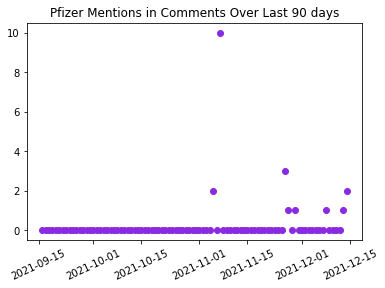

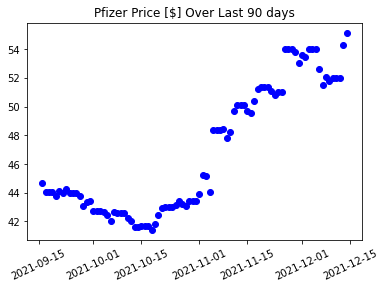

The lag between the max comments and max price is 37 days, 0:00:00


In [9]:
y = {}
yy = {}
for date in x:
    y[date] = sum(comments[comments['date'] == date]['pfe'])
    yy[date] = max(comments[comments['date'] == date]['pfe_price'])
y1 = [y[item] for item in x]
y2 = [yy[item] for item in x]

fig, ax = plt.subplots()
plt.scatter(x=x, y=y1, color=colors[10])
plt.title("Pfizer Mentions in Comments Over Last 90 days")
plt.xticks(rotation=25)

fig, ax = plt.subplots()
plt.scatter(x=x, y=y2, color=colors[9])
plt.title("Pfizer Price [$] Over Last 90 days")
plt.xticks(rotation=25)
plt.show()

pfe_lag = list(yy.keys())[list(yy.values()).index(max(y2))] - list(y.keys())[list(y.values()).index(max(y1))]
print(f'The lag between the max comments and max price is {pfe_lag}')

The results of linear regression can be represented by the function y = 0.5991114267883764 * x + 49.435201384500736.
The correlation coefficient is 0.21745524019402537.
The p-value is 0.11778682266217012.


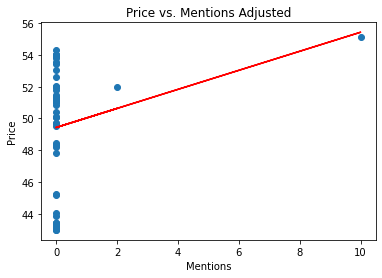

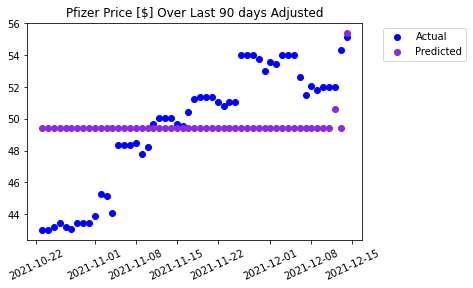

In [10]:
yyy = {} # adjusted prices
for key in yy.keys(): # Shift all of the priecs back by the lag
    yyy[key - pfe_lag] = yy[key]
    
adjusted_price = [] # adjusted price
new_mentions = []
days = [] # corresponding day
for key in yyy.keys(): # For each item in the adjsuted price array, add it to a new list if the date is also in the original array
    if key in y.keys():
        new_mentions.append(y[key])
        adjusted_price.append(yyy[key])
        days.append(key)
        
a = np.array(new_mentions)
b = np.array(adjusted_price)
plt.scatter(x=a, y=b)

# Use stats to get a linear regression model for year and lifeExp column
m, yint, r, p, se = stats.linregress(a, b)
# Print relevant info about the model
print(f'The results of linear regression can be represented by the function y = {m} * x + {yint}.')
print(f'The correlation coefficient is {r}.')
print(f'The p-value is {p}.')

plt.plot(a, m*a+yint, 'r')
plt.title("Price vs. Mentions Adjusted")
plt.xlabel('Mentions')
plt.ylabel('Price')
plt.show()

days = [item+pfe_lag for item in days]
new_actual_price = []
for day in days:
    new_actual_price.append(yy[day])
new_predicted_price = [m*item+yint for item in new_mentions]
fig, ax = plt.subplots()
plt.scatter(x=days, y=new_actual_price, color=colors[9])
plt.scatter(x=days, y=new_predicted_price, color=colors[10])
plt.title("Pfizer Price [$] Over Last 90 days Adjusted")
plt.legend(["Actual", "Predicted"], bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')
plt.xticks(rotation=25)
plt.show()

Since the lag for Pfizer is so long, it wasn't really possible to build a model and the p-value is not significant. More data is needed to predict Pfizer prices.

## Gamestop

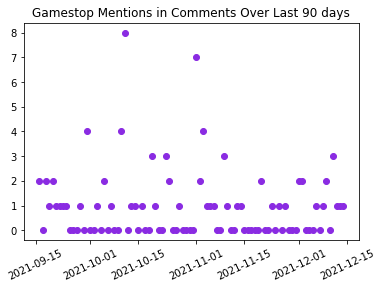

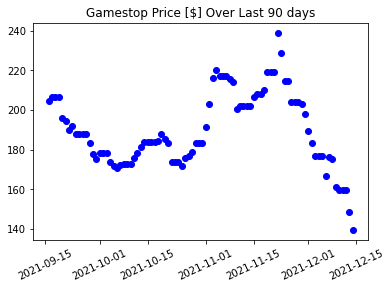

The lag between the max comments and max price is 42 days, 0:00:00


In [11]:
y = {}
yy = {}
for date in x:
    y[date] = sum(comments[comments['date'] == date]['gme'])
    yy[date] = max(comments[comments['date'] == date]['gme_price'])
y1 = [y[item] for item in x]
y2 = [yy[item] for item in x]

fig, ax = plt.subplots()
plt.scatter(x=x, y=y1, color=colors[10])
plt.title("Gamestop Mentions in Comments Over Last 90 days")
plt.xticks(rotation=25)

fig, ax = plt.subplots()
plt.scatter(x=x, y=y2, color=colors[9])
plt.title("Gamestop Price [$] Over Last 90 days")
plt.xticks(rotation=25)
plt.show()

gme_lag = list(yy.keys())[list(yy.values()).index(max(y2))] - list(y.keys())[list(y.values()).index(max(y1))]
print(f'The lag between the max comments and max price is {gme_lag}')

The results of linear regression can be represented by the function y = 0.059305010771992885 * x + 195.71026098788153.
The correlation coefficient is 0.004540453761644519.
The p-value is 0.9755661180977181.


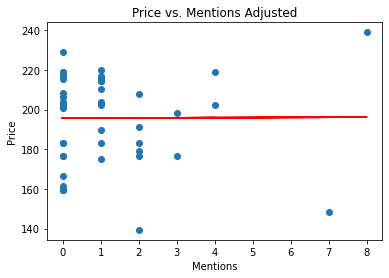

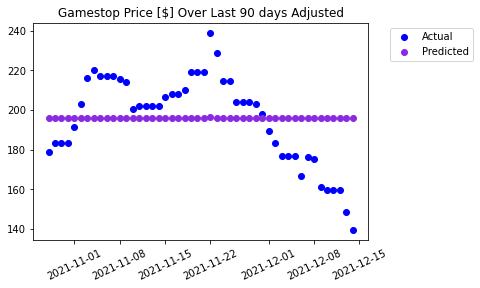

In [12]:
yyy = {} # adjusted prices
for key in yy.keys(): # Shift all of the priecs back by the lag
    yyy[key - gme_lag] = yy[key]
    
adjusted_price = [] # adjusted price
new_mentions = []
days = [] # corresponding day
for key in yyy.keys(): # For each item in the adjsuted price array, add it to a new list if the date is also in the original array
    if key in y.keys():
        new_mentions.append(y[key])
        adjusted_price.append(yyy[key])
        days.append(key)
        
a = np.array(new_mentions)
b = np.array(adjusted_price)
plt.scatter(x=a, y=b)

# Use stats to get a linear regression model for year and lifeExp column
m, yint, r, p, se = stats.linregress(a, b)
# Print relevant info about the model
print(f'The results of linear regression can be represented by the function y = {m} * x + {yint}.')
print(f'The correlation coefficient is {r}.')
print(f'The p-value is {p}.')

plt.plot(a, m*a+yint, 'r')
plt.title("Price vs. Mentions Adjusted")
plt.xlabel('Mentions')
plt.ylabel('Price')
plt.show()

days = [item+gme_lag for item in days]
new_actual_price = []
for day in days:
    new_actual_price.append(yy[day])
new_predicted_price = [m*item+yint for item in new_mentions]
fig, ax = plt.subplots()
plt.scatter(x=days, y=new_actual_price, color=colors[9])
plt.scatter(x=days, y=new_predicted_price, color=colors[10])
plt.title("Gamestop Price [$] Over Last 90 days Adjusted")
plt.legend(["Actual", "Predicted"], bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')
plt.xticks(rotation=25)
plt.show()

Similarly, Gamestop was not mentioned enough in this period to build a model.

# Insights

I was able to build 2 statisticlaly significant models with just 100 comments per day for 90 days. This volume of data only scratches the surface as to how much is out there. Obtaining more comments are more precise intervals would undoubtedly improve the models. Other factors could be taken into account, like score, in order to give more weight to more important comments. Posts could also be incorporated, as they have more metrics. As mentioned earlier, other words besides the company name or ticker could be use as predictors, and could be given different weights dependnig on how closely related they are. An entirely separate analysis could be done on which terms are most closely related. Additionally, rather than predicting the actual price, we could predict the change in price. Using the predicted slope values we could then take the antiderivative and obtain price predictions. 

It was difficult to obtain enough records short ahort amount of time, but if the data were being downloaded in real time each day, we could get a uch better prediction. This technique could even be expanded beyond the stock market, to predict when other events might occur, such as those related to the pandemic.

Hopefully this tutorial has been useful in understanding how to scrape data from Reddit and Yahoo Finance, and how we can apply the data science pipeline in order to obtain meaningful results.